In [1]:
import pandas as pd
import os
from openpyxl import load_workbook
from tqdm import tqdm
from functools import reduce

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
merged_df = pd.read_parquet("../../data/merged_era5data/merged_df.parquet")

### Model training

In [29]:


# Step 1: Aggregate to daily resolution
merged_df["date"] = merged_df["datetime"].dt.date

daily_df = (
    merged_df
    .groupby(["date", "latitude", "longitude"])
    [["temperature", "wind_u", "wind_v", "precipitation", "surface_runoff"]]
    .mean()
    .reset_index()
)

# Step 2: Prepare data for modeling
features = ["temperature", "wind_u", "wind_v", "precipitation"]
target = "surface_runoff"

X = daily_df[features]
y = daily_df[target]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = model.predict(X_test)

rmse = ((y_test - y_pred) ** 2).mean() ** 0.5  # manually compute RMSE

r2 = r2_score(y_test, y_pred)

print(f"✅ XGBoost RMSE: {rmse:.6f}")
print(f"✅ XGBoost R² Score: {r2:.4f}")


✅ XGBoost RMSE: 0.000124
✅ XGBoost R² Score: 0.8955


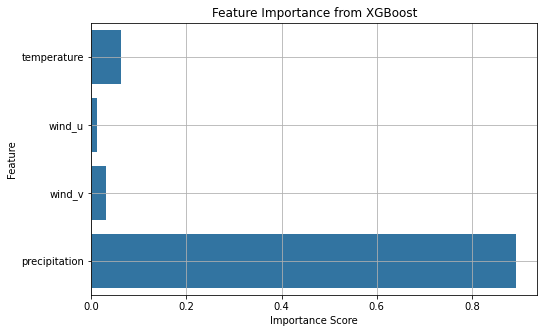

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get importance scores
importance = model.feature_importances_
features = ["temperature", "wind_u", "wind_v", "precipitation"]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


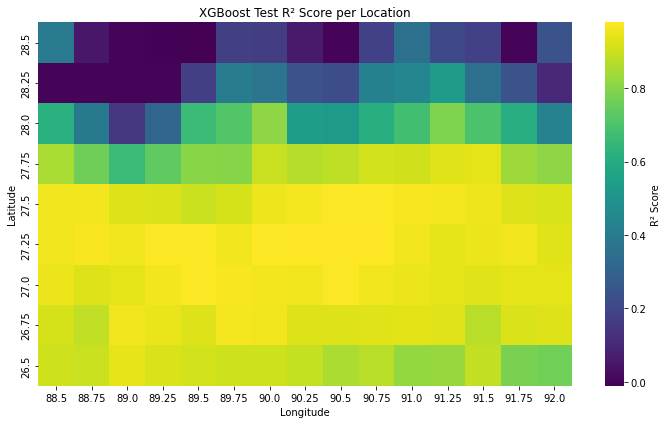

In [34]:
### Want to run this for each spatial unit

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load your aggregated daily DataFrame (if not already loaded)
df = daily_df

# Step 2: Define feature and target columns
features = ['temperature', 'wind_u', 'wind_v', 'precipitation']
target = 'surface_runoff'

# Step 3: Group by spatial location
grouped = df.groupby(['latitude', 'longitude'])

results = []

for (lat, lon), group in grouped:
    if len(group) < 100:  # Skip if not enough data
        continue

    X = group[features]
    y = group[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost
    model = xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Store result
    results.append({'latitude': lat, 'longitude': lon, 'r2_score': r2})

# Step 4: Create results DataFrame
results_df = pd.DataFrame(results)



# Step 5: Plot map of R² scores
plt.figure(figsize=(10, 6))
pivot = results_df.pivot(index='latitude', columns='longitude', values='r2_score')

sns.heatmap(
    pivot.sort_index(ascending=False),  # This flips the y-axis data manually
    cmap='viridis', annot=False, cbar_kws={'label': 'R² Score'}
)

plt.title("XGBoost Test R² Score per Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


